# Reproducibility Lab: Day 2 -- Validation

## EXPLORATORY ANALYSIS

Welcome back. Today you will find out whether the findings you presented in class hold up in an independent dataset.

---

## Part 1: Set Your Topic and Reload Data

Enter your topic below (the same one from Day 1), then run all the cells in order. Your Colab runtime is fresh, so you need to reinstall packages and re-download the data.

In [7]:
# SET YOUR TOPIC (must match Day 1)
# Options: 'pain', 'depression', or 'anxiety'

TOPIC = 'depression'   # <-- change this to match your Day 1 assignment

In [9]:
# Install packages and download data files
import subprocess, sys
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'nilearn', 'statsmodels', '-q'])

import os, urllib.request
base_url = 'https://raw.githubusercontent.com/cmahlen/python-stats-demo/main/'
files_needed = [
    'lab_helpers.py', 'atlas_labels.txt', 'data/roi_mni_coords.npy',
    f'data/{TOPIC}_discovery.npz', f'data/{TOPIC}_validation.npz',
]
os.makedirs('data', exist_ok=True)
for f in files_needed:
    if not os.path.exists(f):
        urllib.request.urlretrieve(base_url + f, f)

import lab_helpers as helpers
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import pandas as pd

print("Setup complete!")

Setup complete!



[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: pip3.11 install --upgrade pip


In [10]:
# Re-run discovery analysis to reconstruct your Day 1 results
helpers.load_dataset(TOPIC, 'discovery')
results = helpers.test_all_edges()

n_sig = (results['p'] < 0.05).sum()
print(f"Discovery dataset: {n_sig:,} edges significant at p < 0.05 (uncorrected)")
print(f"\nTop 5 findings from discovery:")
print(results.head(5)[['ROI_A', 'ROI_B', 'r', 'p']].to_string())

Loaded depression discovery dataset:
  200 subjects
  216 brain regions (ROIs)
  23,220 connectivity edges
  Outcome variable: PHQ9
  Other variables: Age, Sex, BMI, HRV, Sleep_Quality, Physical_Activity, Caffeine_mg, Stress_Level, Rumination, Loneliness, Social_Support, Neuroticism, Self_Esteem, Alcohol_drinks, Screen_Time, Social_Media, Education_yrs, Income_k
Testing all edges vs PHQ9...
Done! 23,220 edges tested (200 subjects).
  Significant at p < 0.05 (uncorrected): 1,148
Discovery dataset: 1,148 edges significant at p < 0.05 (uncorrected)

Top 5 findings from discovery:
                   ROI_A               ROI_B         r         p
0       RH_SomMotB_Aud_1  RH_DefaultB_Temp_1 -0.285475  0.000042
1     LH_VisCent_ExStr_3     RH_SomMotB_S2_4  0.270998  0.000104
2  LH_VisPeri_ExStrInf_1      RH_ContB_IPL_2 -0.270743  0.000106
3     LH_DefaultB_PFCd_3        LH_TempPar_2 -0.264681  0.000152
4     LH_VisCent_ExStr_1     LH_ContA_PFCl_3  0.257823  0.000228


---

## Part 2: Commit Your Claimed Findings

**Before we load the validation data**, enter the specific edges you are planning to present. Copy the exact ROI names from your Day 1 notebook output.

This step matters: you are committing to your claims before seeing whether they replicate. That is what makes this a real test.

In [13]:
# Enter the edges you are claiming as your findings.
# Copy the exact ROI names from your Day 1 results table.
# Format: ('ROI_A_name_here', 'ROI_B_name_here')

my_findings = [
    ('LH_DefaultB_PFCd_3', 'LH_TempPar_2'),   # <-- Replace with your actual edge(s)
    # Add more rows if you are claiming multiple findings:
    # ('ROI_A_name_here', 'ROI_B_name_here'),
]

print("Your claimed findings:")
for i, (a, b) in enumerate(my_findings, 1):
    print(f"  {i}. {a} <-> {b}")

Your claimed findings:
  1. LH_DefaultB_PFCd_3 <-> LH_TempPar_2


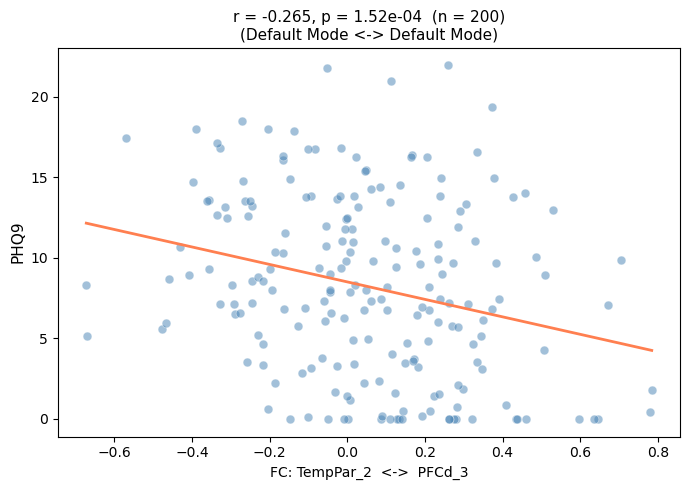

In [15]:
helpers.plot_edge("LH_TempPar_2", "LH_DefaultB_PFCd_3")

---

## Part 3: Validate Your Claimed Findings

Now load the validation dataset and test whether your claimed edges replicate. A finding replicates if it is statistically significant in the same direction in both datasets.

The code below is more complex than what you wrote on Day 1. You do not need to understand every line -- run the cell and focus on the output.

In [17]:
outcome_col = helpers.get_behavior().columns[0]

print("=" * 80)
print("VALIDATION OF YOUR CLAIMED FINDINGS")
print("=" * 80)

claimed_results = []
for roi_a, roi_b in my_findings:
    # Discovery
    helpers.load_dataset(TOPIC, 'discovery')
    disc_edge = helpers.get_edge(roi_a, roi_b)
    disc_out = helpers.get_behavior()[outcome_col].values
    r_disc, p_disc = pearsonr(disc_edge, disc_out)

    # Validation
    helpers.load_dataset(TOPIC, 'validation')
    val_edge = helpers.get_edge(roi_a, roi_b)
    val_out = helpers.get_behavior()[outcome_col].values
    r_val, p_val = pearsonr(val_edge, val_out)

    same_direction = (r_val * r_disc) > 0
    if p_val < 0.05 and same_direction:
        replicated = 'YES'
    elif p_val < 0.05 and not same_direction:
        replicated = 'FLIPPED'
    else:
        replicated = 'NO'

    claimed_results.append({
        'ROI_A': roi_a,
        'ROI_B': roi_b,
        'Discovery_r': round(r_disc, 3),
        'Discovery_p': round(p_disc, 4),
        'Validation_r': round(r_val, 3),
        'Validation_p': round(p_val, 4),
        'Replicated': replicated,
    })

claimed_df = pd.DataFrame(claimed_results)
claimed_df.index = range(1, len(claimed_df) + 1)
print(claimed_df.to_string())

n_rep = (claimed_df['Replicated'] == 'YES').sum()
print(f"\n{n_rep} of {len(my_findings)} claimed finding(s) replicated.")

VALIDATION OF YOUR CLAIMED FINDINGS
Loaded depression discovery dataset:
  200 subjects
  216 brain regions (ROIs)
  23,220 connectivity edges
  Outcome variable: PHQ9
  Other variables: Age, Sex, BMI, HRV, Sleep_Quality, Physical_Activity, Caffeine_mg, Stress_Level, Rumination, Loneliness, Social_Support, Neuroticism, Self_Esteem, Alcohol_drinks, Screen_Time, Social_Media, Education_yrs, Income_k
Loaded depression validation dataset:
  200 subjects
  216 brain regions (ROIs)
  23,220 connectivity edges
  Outcome variable: PHQ9
  Other variables: Age, Sex, BMI, HRV, Sleep_Quality, Physical_Activity, Caffeine_mg, Stress_Level, Rumination, Loneliness, Social_Support, Neuroticism, Self_Esteem, Alcohol_drinks, Screen_Time, Social_Media, Education_yrs, Income_k
                ROI_A         ROI_B  Discovery_r  Discovery_p  Validation_r  Validation_p Replicated
1  LH_DefaultB_PFCd_3  LH_TempPar_2       -0.265       0.0002         0.062        0.3814         NO

0 of 1 claimed finding(s) repl

Loaded depression discovery dataset:
  200 subjects
  216 brain regions (ROIs)
  23,220 connectivity edges
  Outcome variable: PHQ9
  Other variables: Age, Sex, BMI, HRV, Sleep_Quality, Physical_Activity, Caffeine_mg, Stress_Level, Rumination, Loneliness, Social_Support, Neuroticism, Self_Esteem, Alcohol_drinks, Screen_Time, Social_Media, Education_yrs, Income_k
Loaded depression validation dataset:
  200 subjects
  216 brain regions (ROIs)
  23,220 connectivity edges
  Outcome variable: PHQ9
  Other variables: Age, Sex, BMI, HRV, Sleep_Quality, Physical_Activity, Caffeine_mg, Stress_Level, Rumination, Loneliness, Social_Support, Neuroticism, Self_Esteem, Alcohol_drinks, Screen_Time, Social_Media, Education_yrs, Income_k


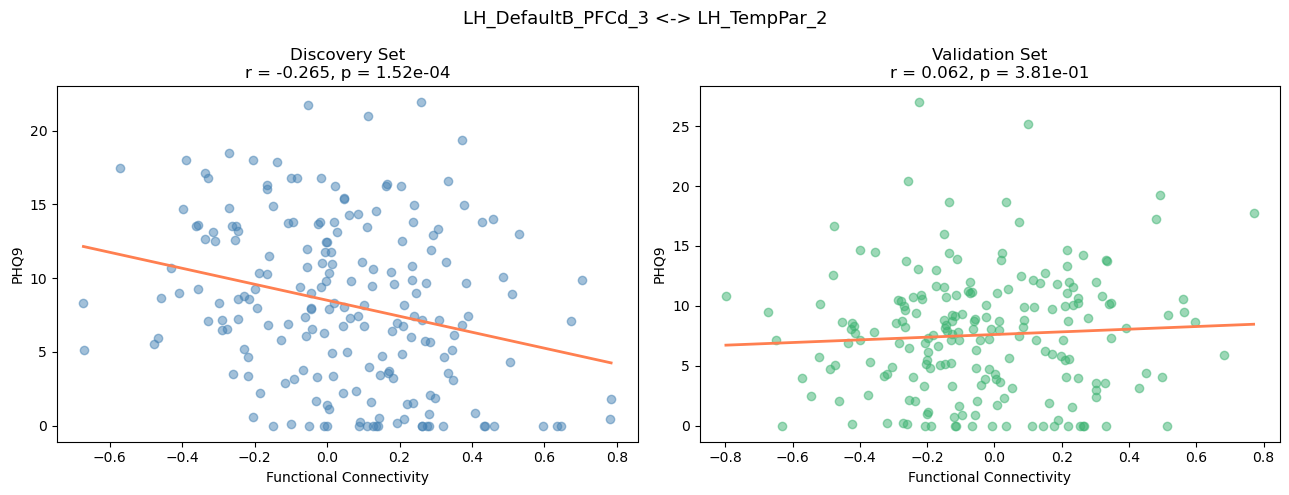

In [19]:
# Side-by-side scatter plots for your claimed findings
for roi_a, roi_b in my_findings:
    fig, axes = plt.subplots(1, 2, figsize=(13, 5))

    # Discovery
    helpers.load_dataset(TOPIC, 'discovery')
    disc_edge = helpers.get_edge(roi_a, roi_b)
    disc_out = helpers.get_behavior()[outcome_col].values
    r_d, p_d = pearsonr(disc_edge, disc_out)

    axes[0].scatter(disc_edge, disc_out, alpha=0.5, color='steelblue')
    z = np.polyfit(disc_edge, disc_out, 1)
    x_line = np.linspace(disc_edge.min(), disc_edge.max(), 100)
    axes[0].plot(x_line, np.polyval(z, x_line), color='coral', linewidth=2)
    axes[0].set_xlabel('Functional Connectivity')
    axes[0].set_ylabel(outcome_col)
    axes[0].set_title(f'Discovery Set\nr = {r_d:.3f}, p = {p_d:.2e}')

    # Validation
    helpers.load_dataset(TOPIC, 'validation')
    val_edge = helpers.get_edge(roi_a, roi_b)
    val_out = helpers.get_behavior()[outcome_col].values
    r_v, p_v = pearsonr(val_edge, val_out)

    axes[1].scatter(val_edge, val_out, alpha=0.5, color='mediumseagreen')
    z = np.polyfit(val_edge, val_out, 1)
    x_line = np.linspace(val_edge.min(), val_edge.max(), 100)
    axes[1].plot(x_line, np.polyval(z, x_line), color='coral', linewidth=2)
    axes[1].set_xlabel('Functional Connectivity')
    axes[1].set_ylabel(outcome_col)
    axes[1].set_title(f'Validation Set\nr = {r_v:.3f}, p = {p_v:.2e}')

    fig.suptitle(f'{roi_a} <-> {roi_b}', fontsize=13)
    plt.tight_layout()
    plt.show()

---

## Part 4: Validate Your Top 5 Discoveries

Now let's test the 5 statistically strongest edges from your discovery dataset -- regardless of which ones you chose to present. This is an objective baseline.

After you see the results, compare: how many of your claimed findings overlap with the top 5? Which set replicated better, and why?

In [21]:
top_5 = results.head(5)

print("=" * 80)
print("VALIDATION OF TOP 5 DISCOVERY EDGES (by p-value)")
print("=" * 80)

top5_results = []
for _, row in top_5.iterrows():
    r_disc = row['r']
    p_disc = row['p']

    helpers.load_dataset(TOPIC, 'validation')
    val_edge = helpers.get_edge(row['ROI_A'], row['ROI_B'])
    val_out = helpers.get_behavior()[outcome_col].values
    r_val, p_val = pearsonr(val_edge, val_out)

    same_direction = (r_val * r_disc) > 0
    if p_val < 0.05 and same_direction:
        replicated = 'YES'
    elif p_val < 0.05 and not same_direction:
        replicated = 'FLIPPED'
    else:
        replicated = 'NO'

    top5_results.append({
        'ROI_A': row['ROI_A'],
        'ROI_B': row['ROI_B'],
        'Discovery_r': round(r_disc, 3),
        'Discovery_p': round(p_disc, 4),
        'Validation_r': round(r_val, 3),
        'Validation_p': round(p_val, 4),
        'Replicated': replicated,
    })

top5_df = pd.DataFrame(top5_results)
top5_df.index = range(1, len(top5_df) + 1)
print(top5_df.to_string())

n_rep = (top5_df['Replicated'] == 'YES').sum()
print(f"\n{n_rep} of 5 top discoveries replicated.")

VALIDATION OF TOP 5 DISCOVERY EDGES (by p-value)
Loaded depression validation dataset:
  200 subjects
  216 brain regions (ROIs)
  23,220 connectivity edges
  Outcome variable: PHQ9
  Other variables: Age, Sex, BMI, HRV, Sleep_Quality, Physical_Activity, Caffeine_mg, Stress_Level, Rumination, Loneliness, Social_Support, Neuroticism, Self_Esteem, Alcohol_drinks, Screen_Time, Social_Media, Education_yrs, Income_k
Loaded depression validation dataset:
  200 subjects
  216 brain regions (ROIs)
  23,220 connectivity edges
  Outcome variable: PHQ9
  Other variables: Age, Sex, BMI, HRV, Sleep_Quality, Physical_Activity, Caffeine_mg, Stress_Level, Rumination, Loneliness, Social_Support, Neuroticism, Self_Esteem, Alcohol_drinks, Screen_Time, Social_Media, Education_yrs, Income_k
Loaded depression validation dataset:
  200 subjects
  216 brain regions (ROIs)
  23,220 connectivity edges
  Outcome variable: PHQ9
  Other variables: Age, Sex, BMI, HRV, Sleep_Quality, Physical_Activity, Caffeine_mg, 

How many of your claimed findings (Part 3) overlap with the top 5? Which set replicated better, and why might that be?

---

## Part 5: Reflection Questions

Before we discuss as a group, take a moment to think about these questions:

1. **How confident were you that your FDR-corrected discoveries were real?**
   - What would have made you more or less confident?

2. **The multiple comparisons problem**
   - You narrowed from 23,220 edges to a specific network to get a gentler FDR correction. Is that the whole story?
   - How many different networks, covariates, and subgroups did you try before finding something that survived correction?
   - Does the FDR correction account for ALL the tests you actually ran?

3. **Analytic flexibility**
   - How many different analysis configurations did you try?
   - If you tried multiple approaches, which results did you choose to present and why?

4. **The extra credit incentive**
   - Did the extra credit incentive affect your analysis decisions?
   - Did you feel pressure to find results that survived FDR correction?
   - How is this similar to pressures in real academic research?

5. **Effect sizes**
   - How strong were the correlations you found (r values)?
   - Are these large enough to be practically meaningful?

Let's discuss these briefly before the class wrap-up.

---

## What Did We Learn?

If your top findings **did not replicate**, you are in good company -- this is the norm for underpowered, uncorrected exploratory analyses. The findings were real in the discovery dataset, but they were likely false positives driven by chance.

This is not a failure. It is the lesson. The reproducibility crisis in science is largely caused by exactly what you just did: testing many things, finding something that works, and reporting it as if it were the only thing you tested.

**The hypothesis-driven group** pre-registered their analysis before running it. We'll find out whether their approach fared better -- and why.

If your findings **did replicate**: think carefully about whether you ran a truly hypothesis-driven analysis, or whether you found your "hypothesis" after exploring the data.